In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt


<Figure size 1500x1000 with 0 Axes>

In [9]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)


full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [84]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [11]:
from statistics import mean, median
listofnums = clusterframes['1']['p-values'].tolist()
print(type(listofnums[0]))
print(mean(listofnums))
print(median(listofnums))

<class 'float'>
0.18463082984096213
0.010000452800129418


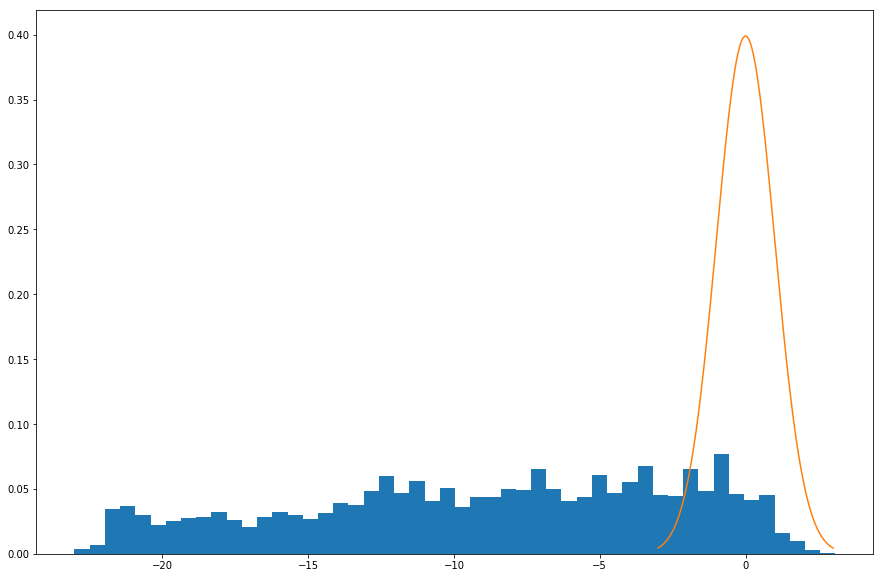

In [34]:
from scipy.stats import norm
def null_testing_cluster(cluster):
    ##Generate Zscores
    p_vals= clusterframes[cluster][f'p-values'].tolist()
    p_significance = norm.ppf(p_vals)
    
    ## Plot distribution of pathway eigenvalues
    plt.figure(figsize=(15, 10))
    plt.hist(p_significance, bins=50, density=True)

    ##Null distribution
    mu, sigma = 0, 1
    x = np.linspace(mu -3 *sigma, mu + 3*sigma, 1000)
    plt.plot(x, norm.pdf(x, 0, 1))
    #plt.savefig(f'cluster_{cluster}_p_distribution.png')
    plt.show()
    
null_testing_cluster('10')


In [ ]:
null_testing_cluster('1')

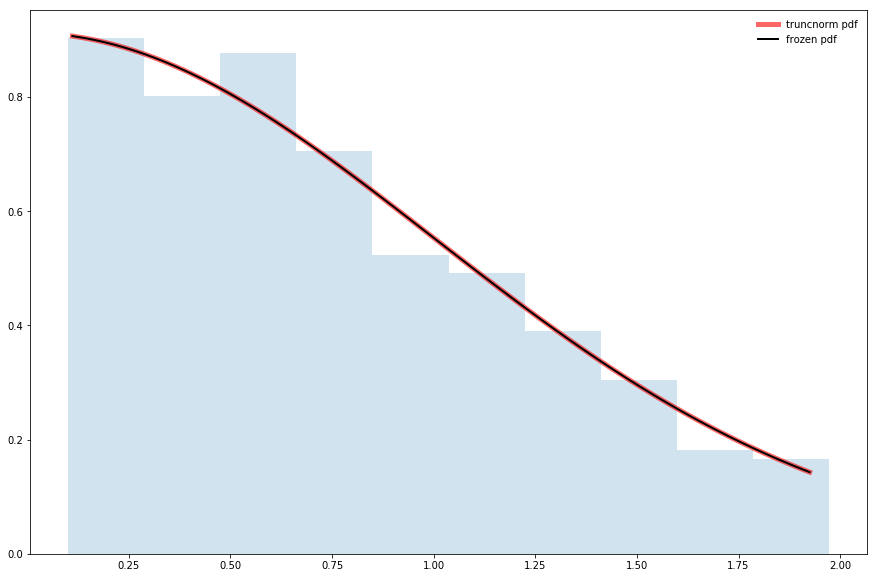

In [52]:
from scipy.stats import truncnorm
fig, ax = plt.subplots(1, 1, figsize=(15,10))
a, b = 0.1, 2
mean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk')
x=np.linspace(truncnorm.ppf(0.01, a, b), truncnorm.ppf(0.99, a, b), 100)
ax.plot(x, truncnorm.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label = 'truncnorm pdf')

rv = truncnorm(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = truncnorm.ppf([0.001, 0.5, 0.999], a, b)
np.allclose([0.001, 0.5, 0.999], truncnorm.cdf(vals, a, b))

r= truncnorm.rvs(a, b, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

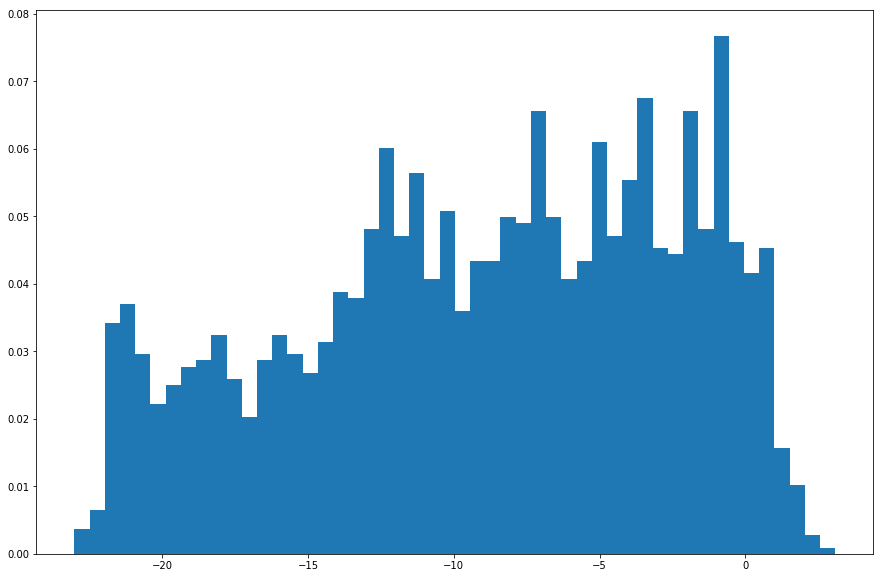

-23.014110679296266
3.0817311784889427
-8.950402823019154
6.471171072801809
[-23.01411068 -22.76075812 -22.58660468 ...   2.26649269   2.36698458
   3.08173118]
[0. 0. 0. ... 0. 0. 0.]


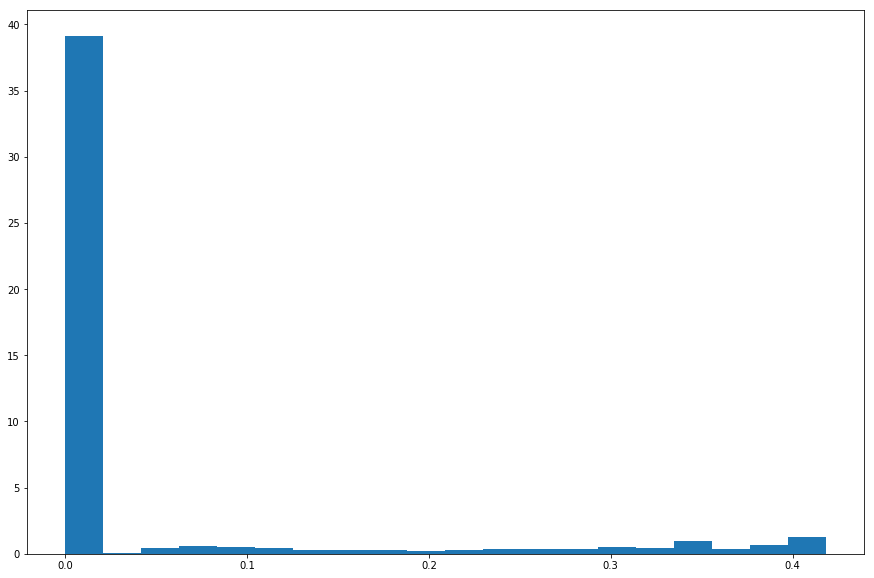

In [65]:
from scipy.stats import truncnorm

def make_pdf(cluster):
    pvalues = clusterframes[cluster][f'p-values'].tolist()
    zvalues = norm.ppf(pvalues)
    plt.figure(figsize=(15, 10))
    plt.hist(zvalues, bins=50, density=True)
    plt.show()
    print(min(zvalues))
    print(max(zvalues))
    print(np.mean(zvalues))
    print(np.std(zvalues))
    print(zvalues)
    a = (min(zvalues) - np.mean(zvalues))/(np.std(zvalues))
    b = (max(zvalues) - np.mean(zvalues))/(np.std(zvalues))
    #a = min(zvalues)
    #b = max(zvalues)
    pdf_ = truncnorm.pdf(zvalues, a, b)
    print(pdf_)
    plt.figure(figsize=(15,10))
    plt.hist(pdf_, bins=20, density=True)
    plt.show()
    
make_pdf('10')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1625.706890542966
            Iterations: 208
            Function evaluations: 1561
            Gradient evaluations: 208
[-0.94740702  1.99839015 -2.07032127  2.03680011]
<class 'numpy.ndarray'>


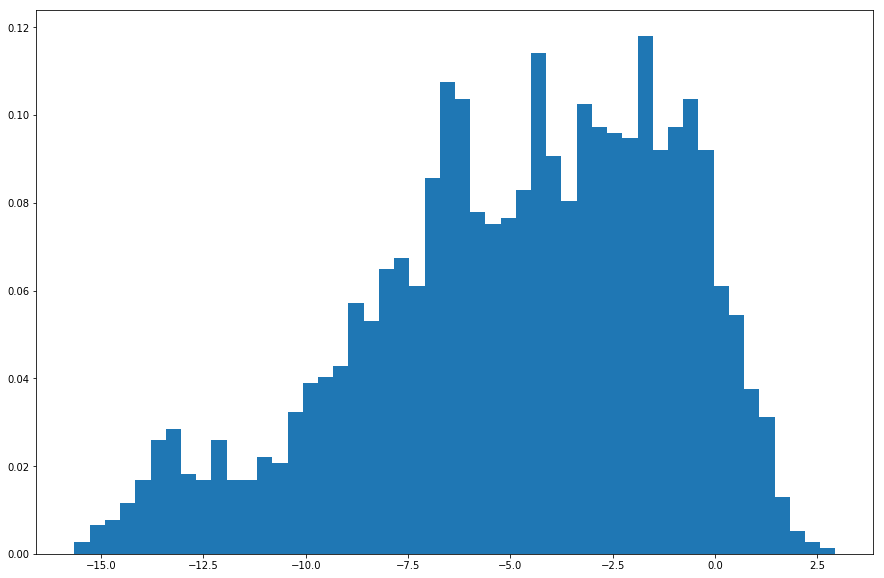

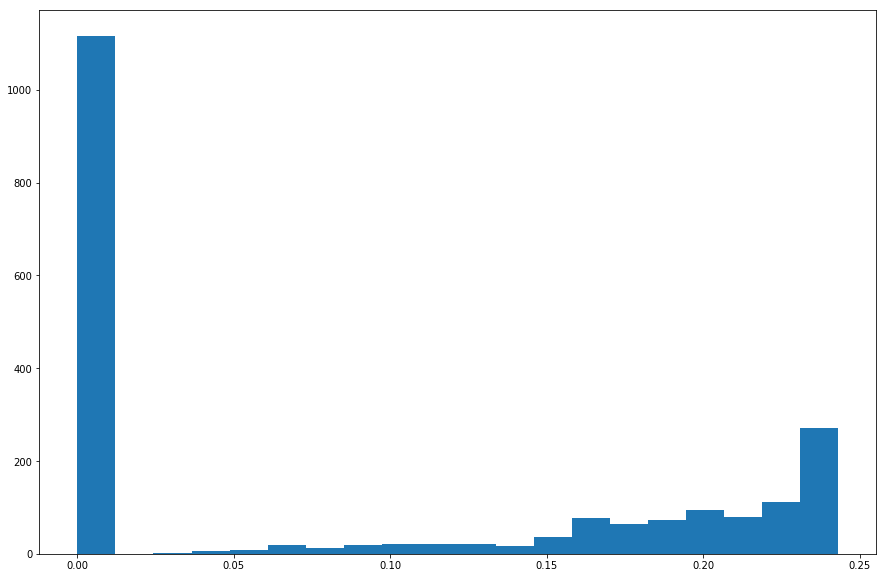

In [111]:
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt


pvalues = clusterframes['4ER+']['p-values'].tolist()
z_scores = norm.ppf(pvalues)

xa = -4
xb = 2

trunc_z = z_scores[z_scores>xa]
trunc_z = trunc_z[trunc_z<xb]

def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

loc = 0
scale = 1

a = (xa - loc)/scale
b = (xb - loc)/scale

loc_guess = 0
scale_guess = 1
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=1000)
print(par)
print(type(par))

plt.figure(figsize=(15, 10))
plt.hist(z_scores, bins=50, density=True)
plt.show()


pdf_ = truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3])


plt.figure(figsize=(15, 10))
plt.hist(pdf_, bins=20)
plt.savefig('cluster_pdf.png')
plt.show()


In [76]:
print(par)

[-0.71611995 -0.1786293   0.6646618   3.72097741]
